In [1]:
import torch
import torch.nn as nn
from functools import reduce
from operator import __add__

class ResBlock(nn.Module):
    def __init__(self, in_channels=3, out_channels=3):
        super(ResBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.prelu = nn.PReLU()

        self.kernel_sizes = (3, 3)
        self.conv_padding = reduce(__add__, 
            [(k // 2 + (k - 2 * (k // 2)) - 1, k // 2) for k in self.kernel_sizes[::-1]])

    def forward(self, input):
        residual = input
        x = nn.ZeroPad2d(self.conv_padding)(input)
        x = self.bn1(self.conv1(x))
        x = self.prelu(x)
        x = nn.ZeroPad2d(self.conv_padding)(input)
        x = self.bn2(self.conv2(x))
        x += residual
        return x

class NoiseGenerator(nn.Module):
    def __init__(self, block, num_of_resblock=5, input_channels=3):
        super(NoiseGenerator, self).__init__()

        self.conv1 = nn.Conv2d(input_channels, 3, kernel_size=3, bias=False)
        self.bn1 = nn.BatchNorm2d(3)
        self.relu1 = nn.ReLU(inplace=True)
        
        self.layers = self._make_layer(block, num_of_resblock)

        self.conv2 = nn.Conv2d(input_channels, 3, kernel_size=3, bias=False)
        self.bn2 = nn.BatchNorm2d(3)
        self.relu2 = nn.ReLU(inplace=True)

        self.conv3 = nn.Conv2d(input_channels, 3, kernel_size=3, bias=False)
        self.bn3 = nn.BatchNorm2d(3)
        self.relu3 = nn.ReLU(inplace=True)

        self.kernel_sizes = (3, 3)
        self.conv_padding = reduce(__add__, 
            [(k // 2 + (k - 2 * (k // 2)) - 1, k // 2) for k in self.kernel_sizes[::-1]])

    def _make_layer(self, block, num_of_resblock):
        layers = []
        for i in range(num_of_resblock):
          layers.append(block(in_channels=3, out_channels=3))
        return nn.Sequential(*layers)

    def forward(self, input):
        x = nn.ZeroPad2d(self.conv_padding)(input)
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)

        residual = x

        x = self.layers(x)

        x = nn.ZeroPad2d(self.conv_padding)(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)

        comb = x + residual

        comb = nn.ZeroPad2d(self.conv_padding)(comb)
        comb = self.conv3(comb)
        comb = self.bn3(comb)
        comb = self.relu3(comb)

        return comb

In [2]:
# model = NoiseGenerator(ResBlock)
# print(model)
# input = torch.ones([4,3,28,28])
# output = model(input)
# print(output.shape)

In [3]:
import torch
import torch.nn as nn
from functools import reduce
from operator import __add__

class ConvLayer(nn.Module):
    def __init__(self, in_channels=3, out_channels=3, stride=2):
        super(ConvLayer, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, 3, stride=stride, bias=False)
        self.bn = nn.BatchNorm2d(out_channels)
        self.lrelu = nn.LeakyReLU(negative_slope=0.2)

    def forward(self, input):
        x = self.bn(self.conv(input))
        # print(x.shape)
        x = self.lrelu(x)
        return x

class Discriminator(nn.Module):
    def __init__(self, block, input_channels=3):
        super(Discriminator, self).__init__()

        self.conv1 = nn.Conv2d(input_channels, 3, kernel_size=3, padding='same', bias=False)
        self.bn1 = nn.BatchNorm2d(3)
        self.relu1 = nn.LeakyReLU(negative_slope=0.2)
        self.channels = [64, 128, 128, 256, 256, 512, 512]
        self.strides = [2, 1, 2, 1, 2, 1, 2]
        self.layers = self._make_layer(block, self.channels, self.strides)

        self.flat = nn.Flatten()
        self.dense = nn.LazyLinear (out_features=1024)
        self.relu2 = nn.LeakyReLU(negative_slope=0.2)
        self.dense2 = nn.Linear(1024, 1)
        self.sig = nn.Sigmoid()


    def _make_layer(self, block, chennels_num, strides):
        layers = []
        layers.append(block(in_channels=3, out_channels=chennels_num[0], stride = strides[0]))
        for i in range(1,len(chennels_num)-1):
          layers.append(block(in_channels=chennels_num[i-1], out_channels=chennels_num[i], stride = strides[i]))
        layers.append(block(in_channels=chennels_num[-2], out_channels=chennels_num[-1], stride = strides[-1]))
        return nn.Sequential(*layers)

    def forward(self, input):
        x = self.conv1(input)
        x = self.bn1(x)
        x = self.relu1(x)
        print(x.shape)

        x = self.layers(x)
        print(x.shape)
        x = self.flat(x)
        x = self.dense(x)
        x = self.relu2(x)
        x = self.dense2(x)
        x = self.sig(x)


        return x

In [4]:
# model = Discriminator(ConvLayer)
# print(model)
# input = torch.ones([4,3,64,64])
# output = model(input)
# print(output.shape)

In [5]:
import ddp
from ddp import Unet
from data import DatasetLoader
import torch
from torch.optim import Adam

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# LOAD MODEL
ddp.MODEL.load_state_dict(torch.load("unet_final.pt"))
ddp.MODEL.to(device)
ddp.BATCH_SIZE=16
NormalDataloader = DatasetLoader("../data/dataset_same_size/train/good",batch=ddp.BATCH_SIZE,size=ddp.IMG_SIZE)
AnomalyDataloader = DatasetLoader("../data/dataset_same_size/train/defect",batch=ddp.BATCH_SIZE,size=ddp.IMG_SIZE)

cuda


In [7]:
# Instantiate generator and discriminator
generator = NoiseGenerator(ResBlock)
discriminator = Discriminator(ConvLayer)
forward = ddp.forward
reverse = ddp.denoise

# Specify loss functions
gan_loss = nn.BCELoss()
aux_loss = nn.MSELoss()  # Change to the appropriate loss function for your task

# Set up optimizers
generator_optimizer = torch.optim.Adam(generator.parameters(), lr=0.0005)
discriminator_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.0005)

# Training loop
num_epochs = 5
for epoch in range(num_epochs):
    for Anomaly, Normal in zip(AnomalyDataloader, NormalDataloader): #normal 不夠的話請用data augmentation補充到跟所有anomaly相同的數量(或是刪掉幾張anomaly)
        print(Anomaly.shape)
        # ============= setting ==========
        batch_size = Anomaly.size(0)

        # Generate fake images
        generated_noise = generator(Anomaly)
        Noised_anomaly = generated_noise + Anomaly

        # Generate noised normal images
        #Noised_normal = forward(Normal, batch=ddp.BATCH_SIZE)
        Noised_normal = forward(Normal, batch=batch_size)

        # Generate Denoised images
        Denoised_normal = reverse(Noised_normal)
        Denoised_anomaly = reverse(Noised_anomaly)


        # =========== Training ==========
        # Train the discriminator
        discriminator_optimizer.zero_grad()
        
        real_labels = torch.ones(batch_size, 1)
        fake_labels = torch.zeros(batch_size, 1)
        
        real_outputs = discriminator(Noised_anomaly)
        fake_outputs = discriminator(Noised_normal)
        
        discriminator_loss = gan_loss(real_outputs, real_labels) + gan_loss(fake_outputs, fake_labels)
        discriminator_loss.backward(retain_graph=True)
        discriminator_optimizer.step()
        
        # Train the generator
        generator_optimizer.zero_grad()
        
        fake_outputs = discriminator(Noised_anomaly)
        
        generator_loss = gan_loss(fake_outputs, real_labels)
        ## generator_loss.backward()
        ## generator_optimizer.step()
        
        # Compute auxiliary loss
        auxiliary_loss = aux_loss(Denoised_normal, Denoised_anomaly)  # Modify according to your task
        
        # Update generator parameters again with auxiliary loss
        ## generator_optimizer.zero_grad()
        (generator_loss + auxiliary_loss).backward(retain_graph=True)
        generator_optimizer.step()
        
        # Print losses or other metrics
        print(f"Epoch [{epoch+1}/{num_epochs}], Generator Loss: {generator_loss.item()}, "
              f"Discriminator Loss: {discriminator_loss.item()}, Auxiliary Loss: {auxiliary_loss.item()}")
        
    torch.save(generator.state_dict(), "generator_%d.pt" %(epoch) )    
    torch.save(discriminator.state_dict(), "discrimina_%d.pt" %(epoch) )

/home/re6111032/miniconda3/envs/dlfinal/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


torch.Size([16, 3, 256, 256])


/home/re6111032/DL_2023_spring/final/src/ddp.py:296: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image=sample_timestep(torch.tensor(image,device=device),t)


torch.Size([16, 3, 256, 256])
torch.Size([16, 512, 13, 13])
torch.Size([16, 3, 256, 256])
torch.Size([16, 512, 13, 13])


In [6]:
# load generator and discriminator
generator = NoiseGenerator(ResBlock)
discriminator = Discriminator(ConvLayer)
forward = ddp.forward
reverse = ddp.denoise
generator.load_state_dict(torch.load("generator_0.pt"))
discriminator.load_state_dict(torch.load("discrimina_0.pt"))

/home/re6111032/miniconda3/envs/dlfinal/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


<All keys matched successfully>

1
Noised Anomaly


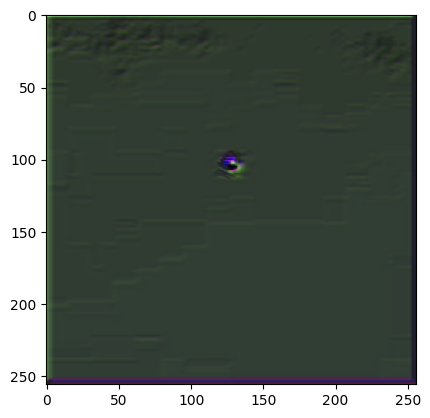

Noised Normal


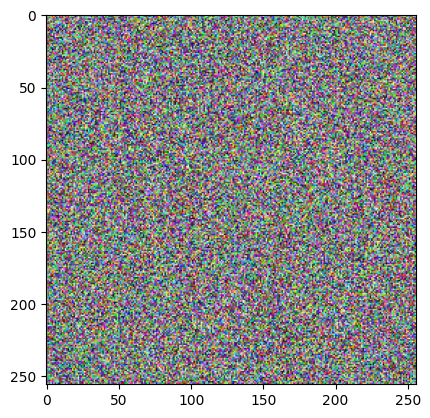

/home/re6111032/DL_2023_spring/final/src/ddp.py:296: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image=sample_timestep(torch.tensor(image,device=device),t)


Denoised Normal


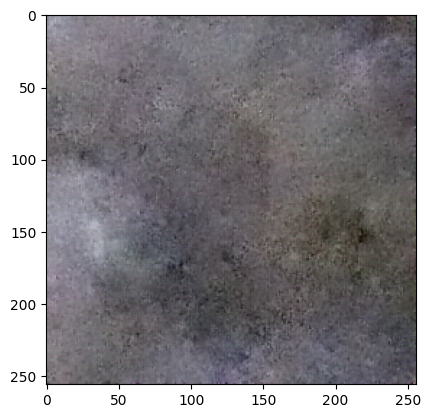

Denoised Anomaly


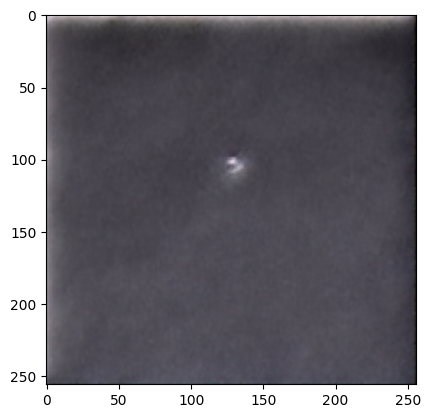

In [16]:
import numpy as np
from PIL import Image
from IPython.display import display
import matplotlib.pyplot as plt

from ddp import show_tensor_image

def pic(img: torch.Tensor):
    img = img.detach().cpu().numpy()
    img = ((img - img.min()) / (img.max() - img.min()) * 255).astype(np.uint8)
    img = np.moveaxis(img, 0, -1)
    img = Image.fromarray(img, mode='RGB')
    # display(img)
    plt.imshow(img)
    plt.show();


count = 1
for Anomaly, Normal in zip(AnomalyDataloader, NormalDataloader):
    batch_size = Anomaly.size(0)
    print(count)
    # img = generator(Anomaly)[0].detach().numpy()
    # img = np.moveaxis(img, 0, -1)
    # img = Image.fromarray(img, mode='RGB')
    # display(img)
    # pic(generator(Anomaly)[0])

    # Generate fake images
    generated_noise = generator(Anomaly)
    Noised_anomaly = generated_noise + Anomaly

    print("Noised Anomaly")
    pic(Noised_anomaly[0])
    # show_tensor_image(Noised_anomaly[0].detach())

    # Generate noised normal images
    #Noised_normal = forward(Normal, batch=ddp.BATCH_SIZE)
    Noised_normal = forward(Normal, batch=batch_size)

    print("Noised Normal")
    # pic(Noised_normal[0])
    show_tensor_image(Noised_normal[0].detach())

    # Generate Denoised images
    Denoised_normal = reverse(Noised_normal)
    Denoised_anomaly = reverse(Noised_anomaly)

    print("Denoised Normal")
    pic(Denoised_normal[0])
    # show_tensor_image(Denoised_normal[0].detach().cpu())
    print("Denoised Anomaly")
    pic(Denoised_anomaly[0])
    # show_tensor_image(Denoised_anomaly[0].detach().cpu())

    count += 1
    if count == 2:
        break

1


/home/re6111032/DL_2023_spring/final/src/ddp.py:296: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image=sample_timestep(torch.tensor(image,device=device),t)


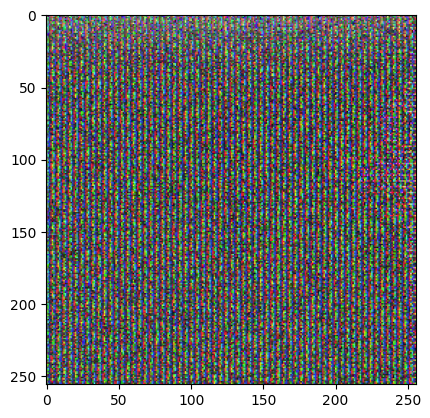

In [35]:
import numpy as np
from PIL import Image
from IPython.display import display
import matplotlib.pyplot as plt

from ddp import show_tensor_image

def pic(img: torch.Tensor):
    img = img.detach().cpu().numpy()
    img = ((img - img.min()) / (img.max() - img.min()) * 255).astype(np.uint8)
    img = np.moveaxis(img, 0, -1)
    img = Image.fromarray(img, mode='RGB')
    # display(img)
    plt.imshow(img)
    plt.show();


count = 1
for Anomaly, Normal in zip(AnomalyDataloader, NormalDataloader):
    batch_size = Anomaly.size(0)
    print(count)
    # img = generator(Anomaly)[0].detach().numpy()
    # img = np.moveaxis(img, 0, -1)
    # img = Image.fromarray(img, mode='RGB')
    # display(img)
    # pic(generator(Anomaly)[0])

    # Generate fake images
    generated_noise = generator(Anomaly)
    Noised_anomaly = generated_noise + Anomaly

  
    Denoised_anomaly = reverse(Noised_anomaly)
    # print(Denoised_anomaly)
    pic(Denoised_anomaly[0])

    count += 1
    if count == 2:
        break

1
Noised Anomaly


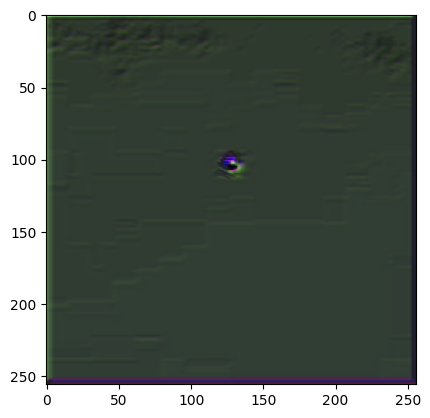

In [17]:
import numpy as np
from PIL import Image
from IPython.display import display
import matplotlib.pyplot as plt

from ddp import show_tensor_image

def pic(img: torch.Tensor):
    img = img.detach().cpu().numpy()
    img = ((img - img.min()) / (img.max() - img.min()) * 255).astype(np.uint8)
    img = np.moveaxis(img, 0, -1)
    img = Image.fromarray(img, mode='RGB')
    # display(img)
    plt.imshow(img)
    plt.show();


count = 1
for Anomaly, Normal in zip(AnomalyDataloader, NormalDataloader):
    batch_size = Anomaly.size(0)
    print(count)
    # img = generator(Anomaly)[0].detach().numpy()
    # img = np.moveaxis(img, 0, -1)
    # img = Image.fromarray(img, mode='RGB')
    # display(img)
    # pic(generator(Anomaly)[0])

    # Generate fake images
    generated_noise = generator(Anomaly)
    Noised_anomaly = generated_noise + Anomaly

    print("Noised Anomaly")
    # print(((Noised_anomaly[0].detach().cpu().numpy() - Noised_anomaly[0].detach().cpu().numpy().min())/(Noised_anomaly[0].detach().cpu().numpy().max() - Noised_anomaly[0].detach().cpu().numpy().min()) * 255).astype(np.uint8))
    pic(Noised_anomaly[0])
    # show_tensor_image(Noised_anomaly[0].detach())

    count += 1
    if count == 2:
        break